## Instruction
In this notebook, we will complete backtest which is the last step.

In [30]:
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

import feather

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
universe_raw = feather.read_dataframe('bitcoin_data/AI_facotor_bitcon_part.feather')
#universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y-%m-%d %H:%M:%S')
universe = universe_raw.set_index(['date']).sort_values(by=['date', 'ts_code'])
print(universe.shape)

(121765, 7)


In [3]:
universe.index.unique()

DatetimeIndex(['2023-01-01 00:00:00', '2023-01-01 01:00:00',
               '2023-01-01 02:00:00', '2023-01-01 03:00:00',
               '2023-01-01 04:00:00', '2023-01-01 05:00:00',
               '2023-01-01 06:00:00', '2023-01-01 07:00:00',
               '2023-01-01 08:00:00', '2023-01-01 09:00:00',
               ...
               '2023-05-25 14:00:00', '2023-05-25 15:00:00',
               '2023-05-25 16:00:00', '2023-05-25 17:00:00',
               '2023-05-25 18:00:00', '2023-05-25 19:00:00',
               '2023-05-25 20:00:00', '2023-05-25 21:00:00',
               '2023-05-25 22:00:00', '2023-05-25 23:00:00'],
              dtype='datetime64[ns]', name='date', length=3479, freq=None)

In [4]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
#universe = universe.loc[(universe.index>='2022-03-01 00:00:00') & (universe.index<='2023-03-28 00:00:00')]
universe.columns

Index(['ts_code', 'close', 'log-ret', 'trade_date', 'alpha_019', 'alpha_078',
       'alpha_AI'],
      dtype='object')

In [5]:
#universe['trade_date'] = universe.index
print(len(universe.ts_code.unique()))
universe.loc[universe.index==universe.index.unique()[0]].shape

35


(35, 7)

In [6]:
alpha_field = [
       'alpha_019', 'alpha_078', 'alpha_AI', 
        ] 

In [ ]:
def alignment_tickers(df):
    ticker_list = df.ts_code.unique()
    calendar = df.index.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.index == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                #'ts_code', 'trade_date', 'close', 'log-ret', 
                # 'alpha_019', 'alpha_022', 'alpha_078', 'alpha_AI'
                data = [pd.Timestamp(dt), ticker, dt, 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date', 'ts_code']) 
    return df

#universe = alignment_tickers(universe)

<AxesSubplot:>

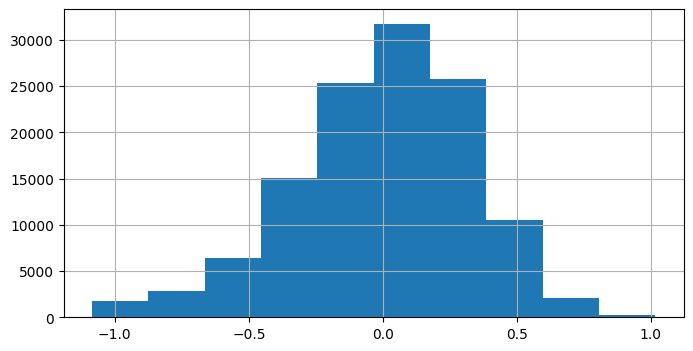

In [7]:
#universe['alpha_AI2'] = (universe['alpha_AI'] + universe['alpha_078'])/2
#print(universe['alpha_AI2'].median())
universe['alpha_AI'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [9]:
import random
all_factors = universe.copy(deep=True)
all_factors = all_factors.sort_values(by=['date', 'ts_code'])

def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-1)
    noise_list = []
    for i in range(df.shape[0]):
        noise = abs(random.gauss(0, 0.2))
        if noise > 0.2:
            noise=0.05
        noise_list.append(noise)
    df['returns_2'] = df['returns_2'] * (1-np.array(noise_list)) \
                    + np.array(noise_list)*(df['close'].pct_change().shift(-1).fillna(0.))
    return df

all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['date', 'ts_code'])
print(universe.shape, all_factors.shape)

(121765, 7) (121765, 8)


In [10]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.03, 0.03)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']=='2023-05-01 00:00:00'])

alpha_019   -0.000021
alpha_078    0.000133
alpha_AI     0.000391
dtype: float64

In [11]:
base_field = ['ts_code', 'trade_date', 'log-ret', 'close']
date_and_code = [ 'ts_code', 'returns_2']

start_time = '2023-01-10 00:00:00'
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df.index>=start_time].sort_values(by=['date', 'ts_code'])
calendar = alpha_df.index.unique() # int64

#only for positive estimate
# for feature in alpha_field:
#     alpha_df[feature] = np.where(alpha_df[feature]>=0.7, alpha_df[feature], np.where(alpha_df[feature]<=-0.7, alpha_df[feature], 0))
#     alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='factor returns regression'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df.index==dt])
facret[calendar[-5]]

factor returns regression: 100%|████████████| 3263/3263 [00:53<00:00, 61.21it/s]


alpha_019    0.005256
alpha_078    0.005747
alpha_AI     0.003161
dtype: float64

#### Veiw Factor Returns

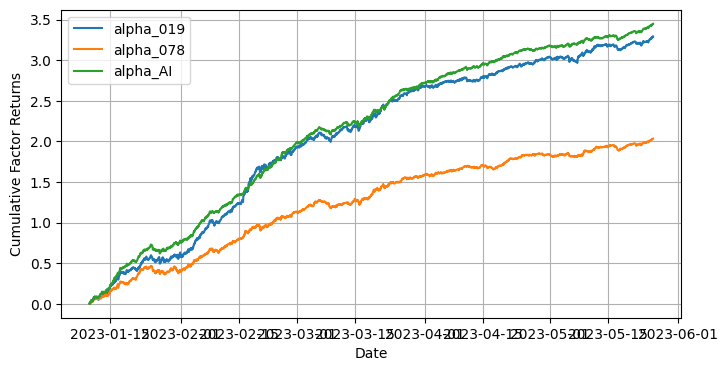

In [12]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in alpha_field:
    plt.plot(facret_df[column].cumsum(), label=column)
    #plt.plot((1+facret_df[column]).cumprod(), label=column)
    
plt.grid(True)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

### PCA model
We use PCA algorithm to estimate risk

In [15]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=210):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [16]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector, F

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i, F = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 216
return date 2023-01-10T00:00:00.000000000


ts_code,ACHUSDT,ADAUSDT,APEUSDT,APTUSDT,ATOMUSDT,AVAXUSDT,BNBUSDT,BTCUSDT,CFXUSDT,DOGEUSDT,...,NEARUSDT,OPUSDT,SANDUSDT,SHIBUSDT,SOLUSDT,STXUSDT,TRXUSDT,UMAUSDT,WOOUSDT,XRPUSDT
ts_code,,,,,,,,,,,,,,,,,,,,,
ACHUSDT,0.006546,0.002134,0.001851,0.001726,0.001598,0.001516,0.001073,0.000449,0.000953,0.001564,...,0.002483,0.002618,0.002739,0.001402,0.002509,0.000913,0.001045,0.000706,0.002068,0.001270
ADAUSDT,0.002134,0.015430,0.005546,0.005134,0.005249,0.005035,0.003471,0.001450,0.002921,0.004988,...,0.007959,0.007809,0.007464,0.004370,0.009664,0.002903,0.003321,0.002404,0.006657,0.004120
APEUSDT,0.001851,0.005546,0.014309,0.006530,0.004318,0.004084,0.003023,0.001309,0.002899,0.004495,...,0.006605,0.007888,0.008942,0.004260,0.005760,0.002830,0.003012,0.001915,0.005737,0.003596
APTUSDT,0.001726,0.005134,0.006530,0.033667,0.005240,0.005532,0.003666,0.001966,0.004390,0.006301,...,0.007029,0.006999,0.012963,0.005143,0.019037,0.004672,0.004286,0.003879,0.005514,0.005756
ATOMUSDT,0.001598,0.005249,0.004318,0.005240,0.008393,0.003829,0.002677,0.001141,0.002358,0.003875,...,0.005917,0.005738,0.006116,0.003455,0.007208,0.002363,0.002571,0.001883,0.005022,0.003207


In [17]:
h=np.array([1/35]*35) 
(np.dot(h, variance_i).dot(h.T))** 0.5

0.068029368578197

In [18]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i, F = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:], residual_i.copy(), F]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 216
(114205, 3) (114205, 9)


### Combine Factors

In [20]:
#'alpha_028', 'alpha_ppo', 'alpha_wtr', 'alpha_AI', 
all_factors['date'] = all_factors['trade_date']#.apply(lambda x: pd.Timestamp(x))
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['date', 'ts_code'])
alpha_df['alpha_all'] = 0.6 * alpha_df['alpha_AI'] + 0.4 * alpha_df['alpha_019']
#alpha_df['alpha_all'] = alpha_df['alpha_AI']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0124693821709378 -1.0556368236093845


In [ ]:
# for dt in alpha_df.index.get_level_values(0).unique():
#     tmp = alpha_df.loc[dt]
#     print(tmp['trade_date'])

In [21]:
print(type(calendar[0]), type(alpha_df.index.get_level_values(0).unique()[0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'> <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [22]:
alpha_df.index.get_level_values(0).unique()

DatetimeIndex(['2023-01-10 00:00:00', '2023-01-10 01:00:00',
               '2023-01-10 02:00:00', '2023-01-10 03:00:00',
               '2023-01-10 04:00:00', '2023-01-10 05:00:00',
               '2023-01-10 06:00:00', '2023-01-10 07:00:00',
               '2023-01-10 08:00:00', '2023-01-10 09:00:00',
               ...
               '2023-05-25 14:00:00', '2023-05-25 15:00:00',
               '2023-05-25 16:00:00', '2023-05-25 17:00:00',
               '2023-05-25 18:00:00', '2023-05-25 19:00:00',
               '2023-05-25 20:00:00', '2023-05-25 21:00:00',
               '2023-05-25 22:00:00', '2023-05-25 23:00:00'],
              dtype='datetime64[ns]', name='date', length=3263, freq=None)

### Backtest by Convex Optimization(Choice one option)

### Option One
- use `cvxpy` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed max risk to endure

In [49]:
calendar = alpha_df.trade_date.unique()
ticker_num = len(alpha_df.index.get_level_values(1).unique())

# get parameter
positions = {}
alpha_df['h_privious'] = 0.
h0 = [0.] * ticker_num
aversion = 0.05
Lambda = 3e-4

In [34]:
alpha_df.head()

close   log-ret trade_date  alpha_019  alpha_078  \
date       ts_code                                                         
2023-01-10 ACHUSDT   0.177140 -0.002378 2023-01-10   0.269404   0.100521   
           ADAUSDT   0.346667  0.005287 2023-01-10   0.193471   0.568640   
           APEUSDT   0.549775  0.019586 2023-01-10  -0.132353  -0.201645   
           APTUSDT   0.600817  0.102758 2023-01-10  -0.907272  -0.991073   
           ATOMUSDT  0.386928  0.008034 2023-01-10   0.230427   0.555560   

                     alpha_AI  residual  alpha_all  h_privious  
date       ts_code                                              
2023-01-10 ACHUSDT   0.524323  0.005870   0.422356         0.0  
           ADAUSDT   0.419792  0.008366   0.329263         0.0  
           APEUSDT   0.067583  0.008703  -0.012391         0.0  
           APTUSDT  -0.567483  0.003957  -0.703399         0.0  
           ATOMUSDT  0.441005  0.004379   0.356774         0.0

In [32]:
variance_all[calendar[100]][4]

array([[0.43424246, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.11202888, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.05492302, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.05372397, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.03672921]])

In [48]:
from helper.project_helper import OptimalHoldings

#dt = '2022-04-10 00:00:00'
dt = calendar[100]
obj_df = alpha_df.loc[alpha_df.index.get_level_values(0)==dt]
alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
optimal_weights = OptimalHoldings(aversion=.1, weights_max=0.3, weights_min=-0.3, lambda_reg=.2).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'], Lambda = Lambda ** 2)
optimal_weights.loc[optimal_weights[0]>=0.005]

,0
ts_code,
ATOMUSDT,0.132519
FTMUSDT,0.300000
LTCUSDT,0.041308
UMAUSDT,0.026173


In [50]:
oh_obj = OptimalHoldings(aversion=aversion, weights_max=0.3, weights_min=-0.3, lambda_reg=0.2)
for dt in tqdm(calendar, desc='optimized holding...'):
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
    # convex optimize
    optimal_weights = oh_obj.find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'],Lambda = Lambda)
    h_optimal = optimal_weights
    # update optimize holding
    obj_df['h_opt'] = h_optimal.values
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal.values

optimized holding...: 100%|█████████████████| 3263/3263 [13:45<00:00,  3.95it/s]


### Option Two
- use `scipy.optimize.fmin_l_bfgs_b` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk 1 posistion map to reduce how much risk

In [ ]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda) \
             + 0.5 * alpha * np.linalg.norm(h) \

             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) \
                + 0.5 * 0.5 * alpha
        return f_hat
    return grad_func

# get parameter
bounds = [(0, 10000)] * ticker_num

# for dt in calendar:
#     # fill yesterday holding
#     obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
#     # convex optimize
#     obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
#     #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
#     # update optimize holding
#     obj_df['h_opt'] = h_optimal
#     obj_df['h_privious'] = h0
#     positions[dt]= obj_df
#     h0 = h_optimal

In [51]:
import copy
positions_bak = copy.deepcopy(positions)

In [ ]:
positions = copy.deepcopy(positions_bak)

2.2978167447381863e-12 -4.4009240696141205e-13
1.6442024170857584e-14 5.828670879282072e-15


<AxesSubplot:>

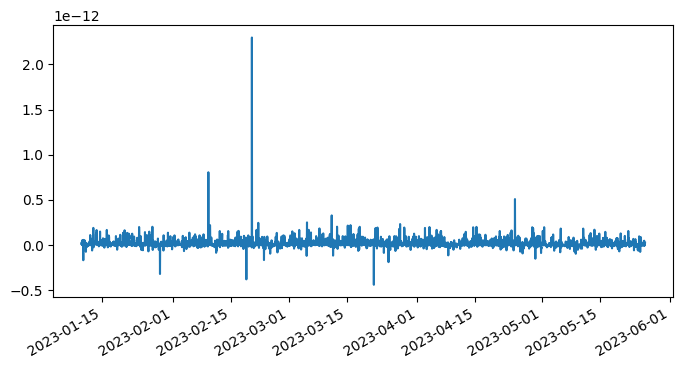

In [52]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S')).plot()

### Money to optimal weights

In [53]:
holding_money = 1e5
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt'] * holding_money
    positions[i]['h_privious'] = positions[i]['h_privious'] * holding_money

In [54]:
h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

49999.999998930565 (6, 10)


close   log-ret    h_privious         h_opt
date                ts_code                                                 
2023-05-25 12:00:00 ACHUSDT   0.560523  0.002260  3.000000e+04   8924.917688
                    APEUSDT   0.364796  0.000924  1.930002e+04  19599.678945
                    DYDXUSDT  0.360275 -0.002512  1.214776e-07  18498.841597
                    ETHUSDT   0.632864 -0.001180  3.825251e-08   2843.310986
                    MANAUSDT  0.172938  0.006243 -2.000000e+04 -19999.999998
                    SANDUSDT  0.169112  0.020889 -3.000000e+04 -30000.000000

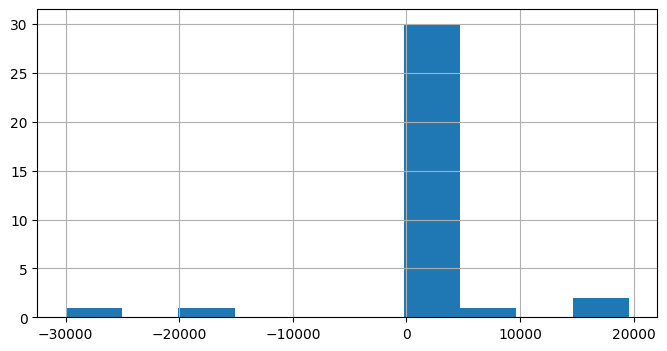

In [61]:
date_hold = list(positions.keys())[-12]
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[(positions[date_hold]['h_opt']>500) | (positions[date_hold]['h_opt']<-500)]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

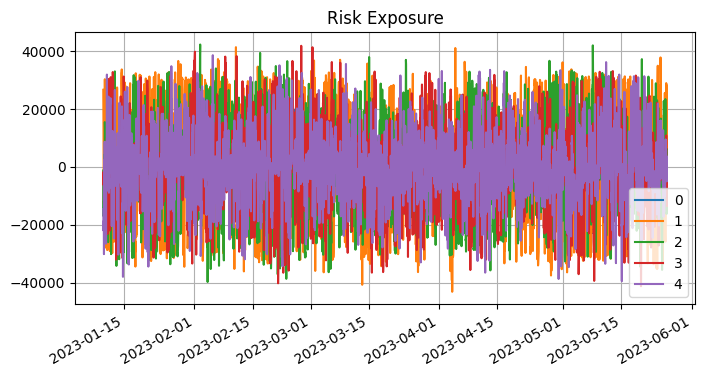

In [62]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

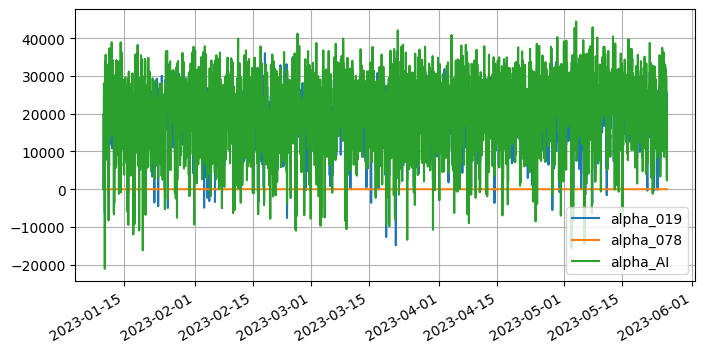

In [63]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_019', 'alpha_078', 'alpha_AI',  'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    B_alpha = B_alpha * [[0.4, 0., 0.6]] 
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=[
                    'alpha_019', 'alpha_078', 'alpha_AI' ])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y-%m-%d %H:%M:%S'), inplace=True)
alpha_exposure_df.plot(grid=True)

In [65]:
len(h_optimal_list)

3263

27909.133077472645 59999.99999990825


<AxesSubplot:>

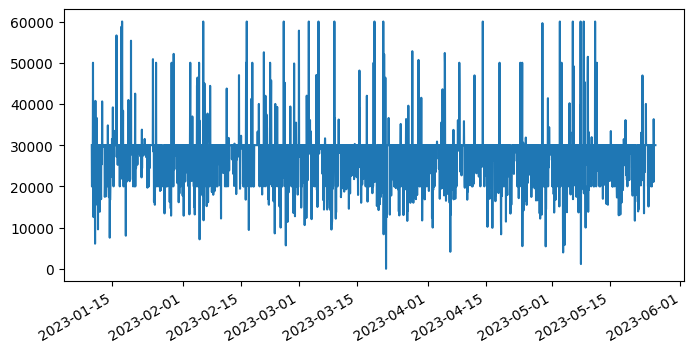

In [66]:
retre_list = []
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    retre_list.append(tmp_change.abs().max())
print(np.sum(retre_list)/len(h_optimal_list), np.max(retre_list))
pd.Series(retre_list, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

118985.20544483274


<AxesSubplot:>

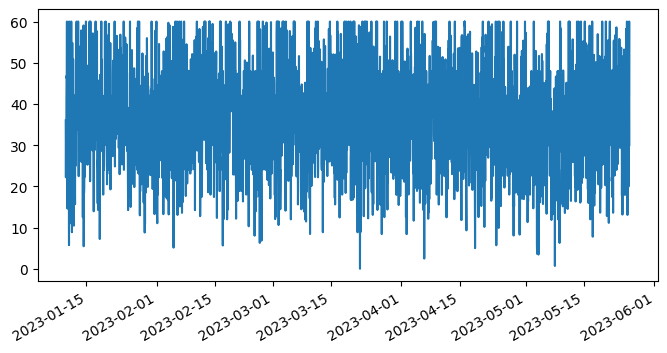

In [68]:
transaction_costs = []
Lambda = 3e-4
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    #costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    costs = sum(abs(tmp_change) * Lambda)
    transaction_costs.append(costs)
print(np.sum(transaction_costs))
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d %H:%M:%S')).plot()

### Profit-and-Loss (PnL)

2023-05-25 21:00:00


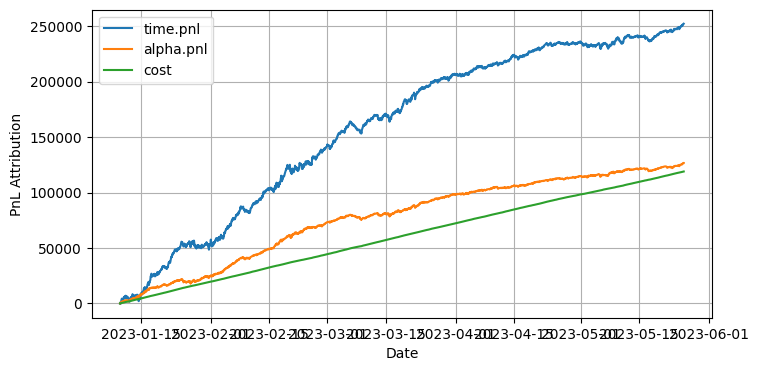

In [73]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d %H:%M:%S')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = all_factors['trade_date'].unique()).iloc[:-2,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[pd.Timestamp(dt)].loc[['alpha_019', 'alpha_078', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.05, 0.05)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        #df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        #df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)/(-1)
        df.at[time_i,"cost"] = transaction_costs[ii]
        #df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            #benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
plt.grid(True)
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [74]:
# 总收益
attr['time.pnl'].sum()

252241.52252768213

In [75]:
# 最小余额
attr['time.pnl'].cumsum().min()

-309.1479555906344

In [76]:
# 最大余额时间
attr['time.pnl'].cumsum().idxmax()

Timestamp('2023-05-25 21:00:00')

In [77]:
# 因子归因收益
attr['alpha.pnl'].sum()

126674.24726292057

In [78]:
# 因子夏普比率
(np.sqrt(252 * 12) * attr['alpha.pnl'].mean()- 0.00017*100000)/attr['alpha.pnl'].std()

8.95609880360338

In [79]:
# 回测夏普比率
(np.sqrt(252 * 12)* attr['time.pnl'].mean() - 0.00017*100000)/attr['time.pnl'].std()

6.708955893857612

In [80]:
# 最大回撤比例及时间
portfolio_values = (100000 + attr['time.pnl'])
retre = ((portfolio_values.cummax() - portfolio_values.cummin())/portfolio_values.cummax())
max_retre_val = retre.max()
max_retre_time = retre.idxmax()
print(max_retre_time, max_retre_val)

2023-02-20 12:00:00 0.0581995815719943


In [81]:
# 胜率
attr.loc[attr['time.pnl']>0].shape[0]/attr.shape[0]

0.5857099049371358

In [86]:
# 平均盈利比率
attr.loc[attr['time.pnl']>0]['time.pnl'].sum()/attr.shape[0]

271.338593788037

In [87]:
# 平均每笔收益
attr['time.pnl'].sum()/attr.shape[0]

77.3509728695744

In [89]:
attr['time.pnl'].cumsum().max()

252241.52252768172

In [92]:
attr.shape

(3261, 3)

In [93]:
open_cap = pd.Series()
close_cap = pd.Series()
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    tmp_change = tmp_change[abs(tmp_change)>1000]
    open_cap = open_cap.append(tmp_change[tmp_change>0])
    close_cap = close_cap.append(tmp_change[tmp_change<0])

In [94]:
open_cap.sum() - close_cap.sum()

395988319.43759024

In [95]:
close_cap.size + open_cap.size

26679